In [252]:
import numpy as np
import os
import kagglehub
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F

In [253]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, ds_file, labels, transform=None):
        self.transform = transform
        data_np = np.load(ds_file)
        labels_np = np.load(labels)
        self.data = torch.from_numpy(data_np)
        self.labels = torch.from_numpy(labels_np)
        self.length = data_np.shape[0]
    def __len__(self):
        return self.length
    def __getitem__(self, index):
        if self.transform:
            self.data = self.transform(self.data)

        return self.data[index], self.labels[index]

Using Colab cache for faster access to the 'crowd-counting' dataset.
Path to dataset files: /kaggle/input/crowd-counting
tensor([36], dtype=torch.uint8)


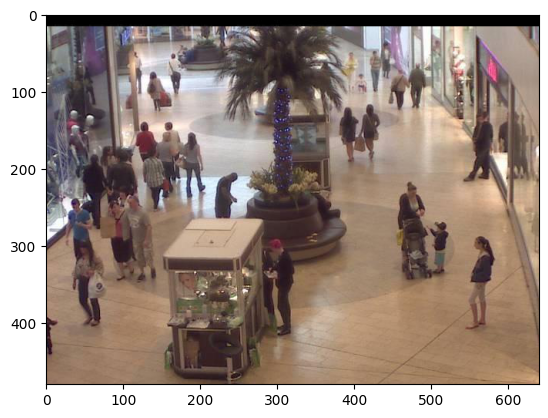

In [254]:
# Download latest version

path = kagglehub.dataset_download("fmena14/crowd-counting")

# train_data = np.load(os.path.join(path, "images.npy"))
all_data = DataSet(os.path.join(path, "images.npy"), os.path.join(path, "labels.npy"))
training_size = int(0.7 * len(all_data))
testing_size = (len(all_data)-training_size)

train_data, test_data = torch.utils.data.random_split(all_data, [training_size, testing_size])
# plt.imshow(train_data[0])
# train_data_tensor = torch.from_numpy(train_data).float()
# print(train_data_tensor.shape)
labels = np.load(os.path.join(path, "labels.npy"))


train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=8)

print("Path to dataset files:", path)

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg)



# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# print(images)


# show images
imshow(images[0])
print(labels[0])

In [255]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*157*117, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 60)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [256]:
def train(network, device):
    for epoch in range(50):  # loop over the dataset multiple times
        correct = 0
        total = 0
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print(inputs.permute(0, 3, 2, 1).shape)
            # print(labels[0])

            # print(inputs.shape[0])
            labels_2d = torch.tensor(()).new_zeros((inputs.shape[0], 60))
            for j in range(inputs.shape[0]):
                labels_2d[j, labels[j].int()] = 1
            labels_2d = labels_2d.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = network(inputs.permute(0, 3, 2, 1).float())
            loss = criterion(outputs.float(), labels_2d.float())
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        print(running_loss)

In [257]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [258]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
net = net.to(device)
train(net, device)

cuda
2769.7508323192596
1169.5459220409393
1113.0253598690033
842.5881099104881
429.13272758573294
215.79946308524814
122.00772843024879
68.57954770352353
43.46596692404819
40.749211644470165
77.74781358751159
87.85840554827337
31.149329470109137
24.73105782112708
26.389826467933215
87.11644508086101
64.42484733649917
20.334487630162386
10.21954622442165
2.403265945199653
4.646147422737828
9.914507879910865
13.29345495394342
10.559253742296965
33.25321199642035
36.57356989496399
32.160914582188944
20.65139649430318
15.110331564351428
24.485105132578024
20.918269268096466
5.122778826045666
7.037206159718323
11.195305518894681
3.7084990326145597
4.069054013930556
36.795896473492
11.415202006952974
23.392146934648196
6.466910699260859
1.7782766634792928
0.6190494897266987
0.007698690761065663
0.002956369134174963
0.0019229872074824073
0.001343395279844728
0.0009643227340365712
0.0007185287007800412
0.0005482148353692651
0.0004336461052307783


Predicted:  tensor(30, device='cuda:0') tensor(37, device='cuda:0') tensor(34, device='cuda:0') tensor(31, device='cuda:0')
Truth:  tensor([17], dtype=torch.uint8) tensor([37], dtype=torch.uint8) tensor([31], dtype=torch.uint8) tensor([28], dtype=torch.uint8)


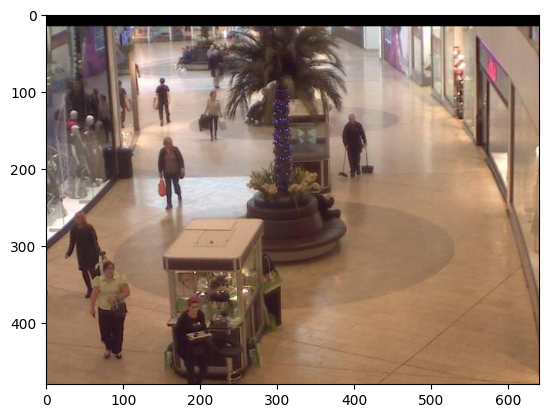

In [259]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

outputs = net(images.to(device).permute(0, 3, 2, 1).float())

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j]
                              for j in range(4)))
# print images
imshow(images[0])


print('Truth: ', ' '.join('%5s' % labels[j]
                              for j in range(4)))